In [1]:
import theano
import theano.tensor as T

Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GT 740M (0000:01:00.0)


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from utils import get_network_str,save_weights,load_weights
from symbols import make_conv,res_unit
import theano.tensor as T
import lasagne
from lasagne import layers as L
from broadcast import BroadcastLayer,UnbroadcastLayer
from lasagne.nonlinearities import rectify
from lasagne.init import HeNormal,Constant

def gen_unet1(data,num_filters,deep,name='unet',first=True):    
    name = name+str(deep)
    res1 = make_conv(data,num_filters,3,name=name+'_in')   
    
    if(deep == 1):
        return res1
    
    res2 = L.Pool2DLayer(res1,2,name=name+'_pool')
    res2 = gen_unet1(res2,num_filters*2,deep-1,name[:-1],False)
    res2 = L.Deconv2DLayer(res2,num_filters*((2**(deep-1))-1),2,2,crop='valid',nonlinearity=None,name=name+'_deconv')
    res2 = L.BatchNormLayer(res2,name=name+'_deconv_bn')
    res2 = L.NonlinearityLayer(res2,rectify,name=name+'_deconv_rectify')
    res = L.ConcatLayer([res2,res1],axis=1, cropping=(None, None, "center", "center"),name=name+'_concat')
    if(first ):
        res = L.Conv2DLayer(res,num_filters*(2**(deep-1)),3,nonlinearity=None,name=name+'_conv',pad='same')
    else:
        res = make_conv(res,num_filters*(2**(deep-1)),3,name=name+'_out')   
    return res


def make_net(input_tensor):
    data_l = L.InputLayer((None,3,None,None)
                           ,input_tensor
                           ,name='data')
    unet = gen_unet1(data_l,6,3,name='unet')
    return unet
data = T.tensor4(name='data')
#data = T.transpose(data,(0,3,1,2))
net = make_net(data)
print get_network_str(net,incomings=True,outgoings=True)


In -->     Layer    --> Out    Description                               
-------    -----    -------    -----------                               
[]         0        [1]        data(None, 3, None, None)                 
[0]        1        [2]        unet3_in_conv(3)(None, 6, None, None)     
[1]        2        [3]        unet3_in_bn(None, 6, None, None)          
[2]        3        [4, 22]    unet3_in_relu(None, 6, None, None)        
[3]        4        [5]        unet3_pool(None, 6, None, None)           
[4]        5        [6]        unet2_in_conv(3)(None, 12, None, None)    
[5]        6        [7]        unet2_in_bn(None, 12, None, None)         
[6]        7        [8, 15]    unet2_in_relu(None, 12, None, None)       
[7]        8        [9]        unet2_pool(None, 12, None, None)          
[8]        9        [10]       unet1_in_conv(3)(None, 24, None, None)    
[9]        10       [11]       unet1_in_bn(None, 24, None, None)         
[10]       11       [12]       unet1_

In [ ]:
from utils import load_weights
load_weights(net,'models/gmm099_loss1137.18')
X = lasagne.layers.get_output(net)
X = X/T.sqrt(T.square(X).sum(1)[:,None,:,:])
#X  =T.transpose(X,(0,2,3,1))
features_fn = theano.function([data],X)

In [5]:
from theano_utils import calc_log_prob_gauss_vector

def calc_log_prob_gauss_vector(Y,means,covars,weights = None):
    """
    calc probability of gmm/gauss vector
    Y: matrix n_samples x n_dim
    means: martix gm_num x n_dim
    covars: matrix gm_num x n_dim
    weights: vector gm_num
    out: vector n_samples
    """
    n_samples, n_dim = Y.shape
    if(weights is None):
        lpr = (-0.5 * (n_dim * T.log(2 * np.pi) + T.sum(T.log(covars), 1)
                      + T.sum((means ** 2) / covars, 1)
                      - 2 * T.dot(Y, (means / covars).T)
                      + T.dot(Y ** 2, T.transpose(1.0 / covars))))
    else:
        lpr = (-0.5 * (n_dim * T.log(2 * np.pi) + T.sum(T.log(covars), 1)
                      + T.sum((means ** 2) / covars, 1)
                      - 2 * T.dot(Y, (means / covars).T)
                      + T.dot(Y ** 2, T.transpose(1.0 / covars))) + T.log(weights))
    lpr = T.transpose(lpr, (1,0))
    vmax = T.max(lpr,axis=0)
    amax = T.argmax(T.exp(lpr- vmax),axis=0)
    out = T.log(T.sum(T.exp(lpr- vmax), axis=0))
    out += vmax
    return out,amax


t_mean = T.fmatrix("mean")
t_cov = T.fmatrix("cov")
t_weights = T.fvector("weights")
t_features = T.fmatrix("features")
prob_fn = theano.function([t_features,t_mean,t_cov,t_weights],\
                          calc_log_prob_gauss_vector(t_features,t_mean,t_cov,t_weights),\
                          allow_input_downcast=True)

In [9]:
from numba import jit
from sklearn import mixture

@jit
def classify(features,gm_num=2,rate=10,ws=(2,2)):
    gmm = mixture.GaussianMixture(covariance_type='diag',n_components=gm_num, max_iter=100)
    #inx = np.random.randint(0,len(features)*ws[0]*ws[1],samples_to_fit,dtype=np.int)
    mask = np.zeros((features.shape[0],features.shape[1],features.shape[2]),dtype=np.uint8)
    for i in range(features.shape[1]//ws[0]):
        for j in range(features.shape[2]//ws[1]):
            vec_to_classify = features[:,i*ws[1]:(i+1)*ws[1],j*ws[0]:(j+1)*ws[0],:].reshape((-1,features.shape[-1]))
            gmm.fit(vec_to_classify)
            rates = gmm.weights_/np.linalg.norm(gmm.covariances_,axis=1)
            score,amax = prob_fn(vec_to_classify,gmm.means_,gmm.covariances_,gmm.weights_)
            score = score.reshape((len(mask),ws[1],ws[0]))
            amax = amax.reshape((len(mask),ws[1],ws[0]))
            mask[:,i*ws[1]:(i+1)*ws[1],j*ws[0]:(j+1)*ws[0]][(score > rate)&(amax == rates.argmax())] = 255
    return mask
    

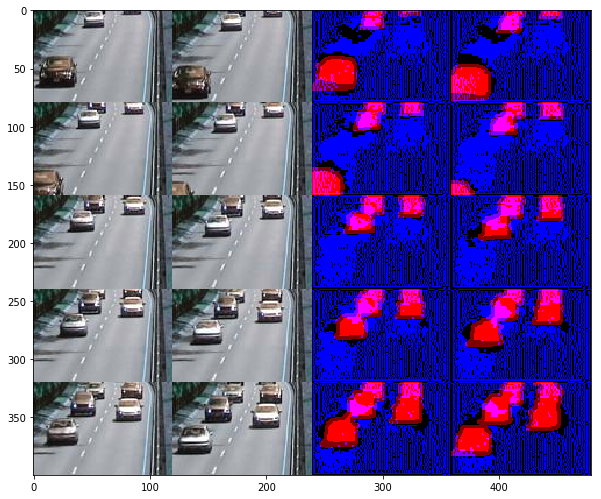

In [11]:
import os
folder = '/media/data/Programming/motion_segmentation/unet_segmentation/dataset/baseline/highway'

def resize(im,mask,size):
    im = cv2.resize(im,size)
    mask = cv2.resize(mask,size)
    mask[mask < 30] = 0
    mask[(mask >=30)&(mask <230)] = 255//2
    mask[(mask >=230)] = 255
    return im,mask
    
def iterate_video(folder,min_rate = 0.01):
    for name in [i[2:-4] for i in os.listdir(folder+'/input') if (i[-4:] == '.jpg')]:
        mask = cv2.imread(folder+'/groundtruth/gt'+name+'.png',0)
        if((mask[(mask>30)&(mask < 230)].size > mask.size//2) | (mask[mask > 230].size < min_rate*mask.size)):
            continue
        im = cv2.imread(folder+'/input/in'+name+'.jpg')
        yield im,mask
    
def iterate_bathced(folder,num_frames,size):
    imgs  = np.zeros((num_frames,size[1],size[0],3),dtype=np.uint8)
    masks = np.zeros((num_frames,size[1],size[0]),dtype=np.uint8)
    for i,(im,mask) in enumerate(iterate_video(folder)):
        im,mask = resize(im,mask,size)
        imgs[i % num_frames] = im
        masks[i % num_frames] = mask
        if((i+1)%num_frames == 0):
            yield imgs,masks

def draw(_imgs,_mask,_out,cols=10,rows=10):
    res =_imgs[:cols*rows,...].copy()
    _,h,w,c = res.shape
    mask = np.zeros_like(res)
    res = np.transpose(res.reshape((rows,cols,h,w,c)),(0,2,1,3,4)).reshape((rows*h,cols*w,c))
    mask[...,0] = _mask[:cols*rows,:,:]
    mask[...,2] = _out[:cols*rows,:,:]
    mask = np.transpose(mask.reshape((rows,cols,h,w,c)),(0,2,1,3,4)).reshape((rows*h,cols*w,c))
    plt.figure(figsize=(10,10))
    plt.imshow(np.concatenate((res,mask),axis=1))
    plt.show()

for imgs,masks in iterate_bathced(folder,100,(320,240)):
    imgs =imgs[:,:80,170:170+120]
    masks = masks[:,:80,170:170+120]
    features = features_fn(np.transpose(imgs,(0,3,1,2)).astype(np.float32))
    features = np.transpose(features,(0,2,3,1))
    out = classify(features)
    draw(imgs[::10],masks[::10],out[::10],2,5)
    break

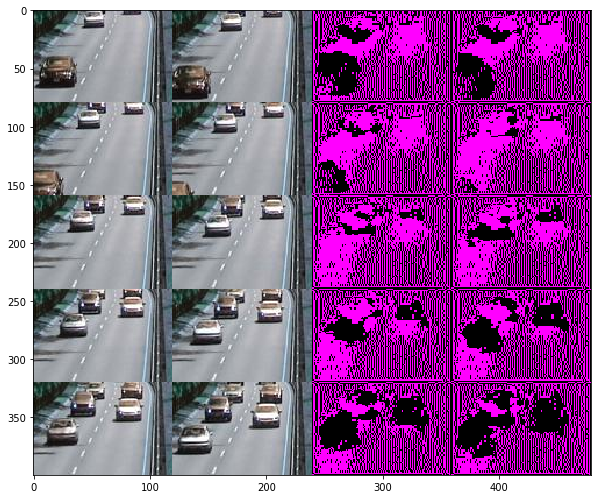

In [12]:

out = classify(features,rate=20)
draw(imgs[::10],out[::10],out[::10],2,5)

In [10]:

f = features

In [35]:
imgs.shape

(100, 80, 120, 3)

In [16]:

#features = imgs

In [88]:
print features.shape,masks.shape

(100, 80, 120, 24) (100, 80, 120)


[ 135.71054167   12.87196214  202.46539479]


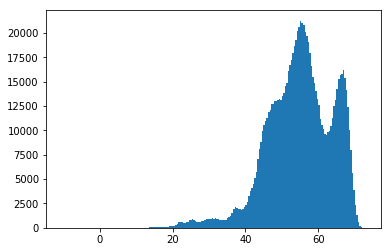

In [138]:

gmm = mixture.GaussianMixture(covariance_type='diag',n_components=3, max_iter=1000)
vec_to_classify = features.reshape((-1,features.shape[-1]))
gmm.fit(vec_to_classify[masks.flatten()<100])
rates = gmm.weights_/np.linalg.norm(gmm.covariances_,axis=1)
print rates
score,amax = prob_fn(vec_to_classify,gmm.means_,gmm.covariances_,gmm.weights_)
plt.hist(score,bins=200)
plt.draw()          

In [139]:
amax = amax.reshape(features[:,...].shape[:-1])

In [140]:
m = np.zeros_like(amax)

In [141]:
rates = gmm.weights_/np.linalg.norm(gmm.covariances_,axis=1)
print rates

[ 135.71054167   12.87196214  202.46539479]


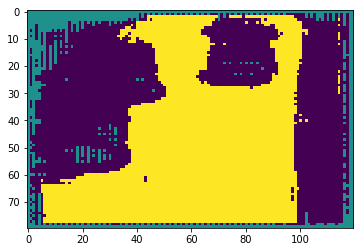

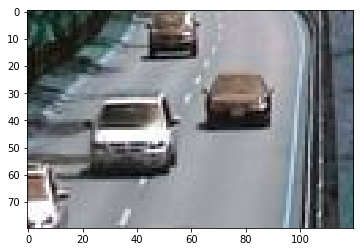

In [142]:
plt.imshow(amax[10])
plt.show()
plt.imshow(imgs[:,...][10])
plt.show()

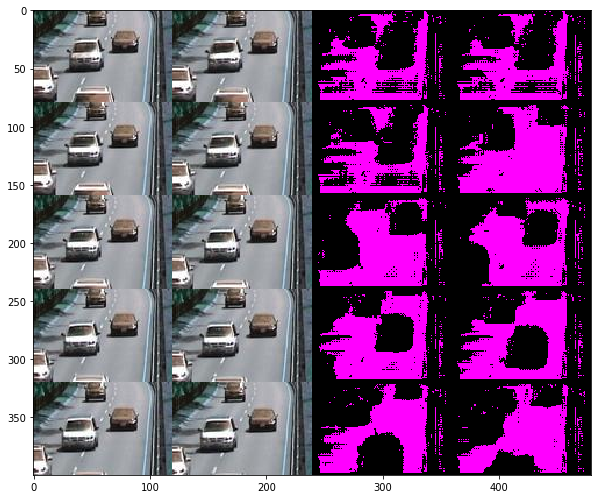

In [146]:
out = np.zeros_like(masks)
out[score.reshape(out.shape) > 60] = 255
draw(imgs[:10],out,out,cols=2,rows=5)

In [ ]:
class MOGSegmentator:
    def __init__(self,n_comp):
        self.n_comp = n_comp
        self.gmm = mixture.GaussianMixture(covariance_type='diag',n_components=n_comp, max_iter=100)
    def segment(self,features):
        

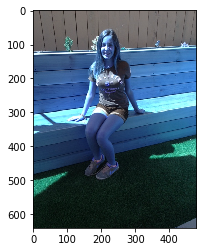

In [70]:
img =cv2.imread('img_1742.jpg')
plt.imshow(img)
features = features_fn(np.transpose(img,(2,0,1))[np.newaxis].astype(np.float32))

In [71]:
s = slice(200,350),slice(340,400),slice(None,None)

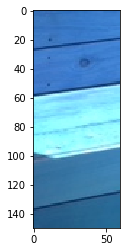

In [72]:
plt.imshow(img[s])

In [73]:
features= np.transpose(features[0],(1,2,0))
features = img.astype(np.float32)

In [74]:
gmm = mixture.GaussianMixture(covariance_type='diag',n_components=5, max_iter=100)
train = features[s]
print train.shape
gmm.fit(train.reshape((-1,features.shape[-1])))
score,amax = prob_fn(features.reshape((-1,features.shape[-1])),gmm.means_,gmm.covariances_,gmm.weights_)
score = score.reshape(features.shape[:-1])

(150, 60, 3)


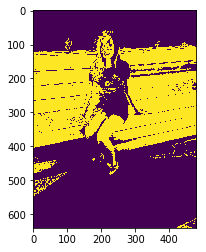

In [83]:
mask = np.zeros_like(score)
mask[score > -20] = 255
plt.imshow(mask)